In [23]:
####
# @author: Nwamaka Nzeocha and Fabian Okeke
# @course: CS 5304/Data Science in the Wild
####

# Environment setup

 - useful tensor flow notebook: 
      - http://bit.ly/1NjhcfQ
      - http://katbailey.github.io/post/neural-nets-in-python/

 - pip install scikit-learn (or https://sourceforge.net/p/scikit-learn/mailman/message/34677778/)
 - pip install --upgrade https://storage.googleapis.com/tensorflow/mac/tensorflow-0.8.0-py2-none-any.whl
 - dataset:
     - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_tst.gz
     - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_val.gz
     - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_trn.gz

# Add libraries and relevant functions

In [192]:
import random
import os.path
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_svmlight_file


#############
# helper functions
#############
def exists(filepath):
    return os.path.exists(filepath)

def get_data(filepath):
    data = load_svmlight_file(filepath)
    return data[0], data[1]

# todo

- is there a direct function to use instead of load_svmlight_file??
- can you directly load the tar.gz file??
- how to do brier curve??
- can you use MLP from sklearn instead of manually implementing yours?
- is there a way to make the training faster?
- what parameters should you tweak in: LR and MLP?

# Split training data into smaller files

In [211]:
if not exists('trainingaa'):
    !wc -l 100000 'a4_smvl_trn' training
else:
    print 'training file already split.'

training file already split


# Load and train model

In [173]:
# get all training files
cwd = os.getcwd()
tr_files = [f for f in os.listdir(cwd) if 'training' in f]

# create model
lr = SGDClassifier(loss="log")
classes = [1, -1]

start = time()
for f in tr_files:
    X_train, y_train = get_data(f)
    lr.partial_fit(X_train, y_train, classes=classes)
    print '%s finished...' % f
print 'All completed.'
print 'Spent time:', time() - star

trainingaa
file size: 891115827
trainingaa finished...
trainingab
file size: 947808879
trainingab finished...
trainingac
file size: 900102567
trainingac finished...
trainingad
file size: 892317123
trainingad finished...
trainingae
file size: 798194430
trainingae finished...
All completed.


In [187]:
lr

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

# Find best model parameters using validation set

# Get best parameters for a given model using training and validation data

In [313]:
def get_best_params(model, train_file, va_file):
    """
    Find the best hyper parameters for model given the training and validation data
    
    
    Parameters
    -----
    model: machine learning model such as Logistic Regression, MultiLayer Perceptron
    
    train_file: file containing training data
    
    va_file: file containing validation data
    
    Returns
    ------
    results needed
    """
    
    # train
    start = time()
    X_train, y_train = get_data(train_file)
    print "Training time (secs):", time() - start

    
    # validate
    start = time()
    X_va, y_va = get_data(va_file)
    print "Validation time (secs):", time() - start

    
    # choose model
    if model == "LR":
        model = LogisticRegression()
    elif model == "MLP":
        model = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    
    # predict accuracy
    # print 'Validation accuracy:', metrics.accuracy_score(y_va, y_pred)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_va)
    accuracy = metrics.accuracy_score(y_va, y_pred)
    
    # compute pre-calibration brier loss
    # predict_proba returns array results according to format of lr.classes_ = [-1, 1]
    # in our case 1 is the positive label for computing brier score
    # print "Pre-calibration brier loss:", metrics.brier_score_loss(y_va, y_prob, pos_label=1)
    y_prob = model.predict_proba(X_va)[:,1] 
    brier_loss = metrics.brier_score_loss(y_va, y_prob, pos_label=1)
    
    return (y_pred, y_va, accuracy, brier_loss)

In [314]:
results_LR = get_best_params("LR", 'trainSmall', 'vaSmall')

Training time (secs): 1.93264007568
Validation time (secs): 1.73336696625


# ROC curves, Brier Score, Accuracy scores, AUC scores

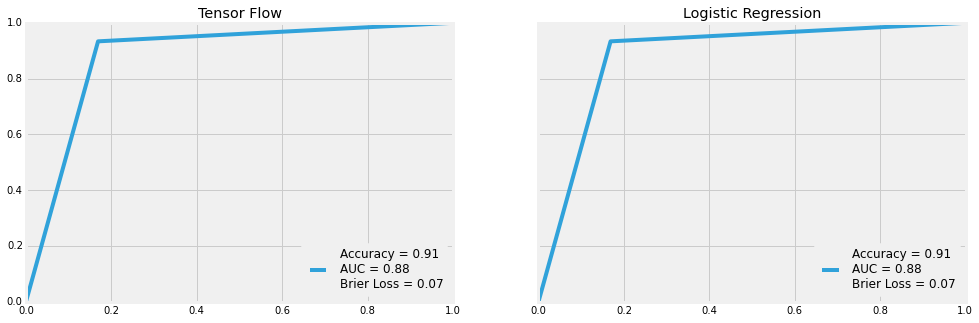

In [317]:
y_predictions = {
    'Logistic Regression': results_LR,
    'Tensor Flow': results_LR
}

fig, axes = plt.subplots(1, len(y_predictions), sharey=True)
fig.set_size_inches(15,5)
i = 0

for title, results in y_predictions.items():
    y_pred, y_va, accuracy, brier_loss = results
    
    fpr, tpr, thresholds = metrics.roc_curve(y_pred, y_va, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    label = 'Accuracy = %0.2f \nAUC = %0.2f \nBrier Loss = %0.2f' % (accuracy, auc, brier_loss)

    axes[i].plot(fpr, tpr, label=label)
    axes[i].set_title(title)
    axes[i].legend(loc='lower right')
    i += 1

# old train & validate with smaller data

In [283]:
from time import time

# training
start = time()
X_train, y_train = get_data('trainSmall')
print "Training time (secs):", time() - start

# validation
start = time()
X_va, y_va = get_data('valSmall')
print "Validation time (secs):", time() - start

# prediction accuracy
prediction = lr.predict(X_va)
print 'Validation accuracy:', metrics.accuracy_score(y_va, prediction)

# classes
print 'Model classes:', lr.classes_

# pre-calibration brier loss
# predict_proba returns array results according to format of lr.classes_ = [-1, 1]
# in our case 1 is the positive label for computing brier score
y_prob = lr.predict_proba(X_va)[:,1] 
print "Pre-calibration brier loss:", metrics.brier_score_loss(y_va, y_prob, pos_label=1)

Training time (secs): 1.9863858223
Validation time (secs): 1.70349502563
Validation accuracy: 0.9015
Model classes: [-1  1]
Pre-calibration brier loss: 0.0707846607367


In [285]:
help(metrics.accuracy_score)

Help on function accuracy_score in module sklearn.metrics.classification:

accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
    Accuracy classification score.
    
    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.
    
    Read more in the :ref:`User Guide <accuracy_score>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    normalize : bool, optional (default=True)
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    
   

# Fit logistic regression model

In [205]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
predicted_LR = model_LR.predict(X_va)
print 'model_LR accuracy:', metrics.accuracy_score(y_va, predicted_LR)

model_LR accuracy: 0.9108


# Using tensor flow

In [209]:
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model_MLP.fit(X_train, y_train)
predicted_MLP = model_MLP.predict(X_va)

model_MLP

ImportError: cannot import name MLPClassifier

# Pre calibration Brier loss and Brier curves

In [ ]:
print "pre-calibration brier loss:"
print "pre-calibration brier curve:"

# Post calibration Brier loss and Brier curves

In [ ]:
print "post-calibration brier loss:"
print "post-calibration brier curve:"